# Hacathon America Express

### Machine Learning Hackathon:

**Problem Statement**
* A mid-sized private bank that includes a variety of banking products, such as savings accounts, current accounts, investment products, credit products, and home loans.
* The task is to predict the next set of products (upto 3 products) for a set of customers (test data) based on their demographics and current product holdings.

**Approach**
* It is Multi label Classification problem, where in we have to predicts the top 3 production only out of 22 types of different products for the Y Variable
* Products (both B1 and B2) are converted to multi-hot encodings. There are 22 types of products.
* Age and Vintage Variable were scaled down by Standardization
* Binary label was for Gender and City_Category,  Variables
* One hot encoding was used for Customer_Category

**Project Flow**
* Feature Engineering and EDA
* Split to train and test
* Standardization 
* Model Building
* Model Evaluation 
* Prediction on Given Test Set

**Modeling**
* Neural Network is used with with # hidden layers of 32,26,8 
* Leaky Relu Activation function is used for the input and the hidden layers to avoid dead relu
* Sigmoid Activation function is used for the output layer
* Adam optimizer is used for faster learning
* Used BinaryCrossEntropy loss since it is a Multi Label problem
* Avg_Precision_Score is used as a evaluation matrix
   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import average_precision_score, accuracy_score

from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

import catboost
from catboost import CatBoostClassifier

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU, ELU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings

warnings.filterwarnings('ignore')

### Feature Engineering + EDA

In [28]:
# cannot use this as the columns will be string
# df = pd.read_csv("train_go05W65.csv")

# convert the string columns to list which will assit us to encode later on
df = pd.read_csv('train_go05W65.csv',
                 converters={
                     "Product_Holding_B1": literal_eval,
                     "Product_Holding_B2": literal_eval
                 })

In [29]:
df.head()

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
0,CC264719,Male,41,14,0,C1,S3,[P16],[P8]
1,CC209679,Female,47,14,1,C1,S2,"[P13, P20]",[P3]
2,CC319633,Female,59,14,0,C2,S2,[P11],[P00]
3,CC231413,Female,32,16,0,C1,S2,"[P8, P13]",[P6]
4,CC259633,Male,30,15,0,C2,S3,"[P16, P17, P21]","[P8, P12]"


In [30]:
mlb = MultiLabelBinarizer(sparse_output=False)

In [31]:
# droped customer id and y variable
X_train = df.iloc[:, 1:-1]
X_train

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1
0,Male,41,14,0,C1,S3,[P16]
1,Female,47,14,1,C1,S2,"[P13, P20]"
2,Female,59,14,0,C2,S2,[P11]
3,Female,32,16,0,C1,S2,"[P8, P13]"
4,Male,30,15,0,C2,S3,"[P16, P17, P21]"
...,...,...,...,...,...,...,...
37743,Male,28,24,1,C1,S2,[P16]
37744,Male,36,11,0,C2,S2,"[P16, P17, P21]"
37745,Male,44,26,1,C2,S2,[P14]
37746,Female,56,15,1,C1,S2,"[P12, P13]"


In [32]:
# y variable
y_train = pd.DataFrame(mlb.fit_transform(df.pop("Product_Holding_B2")),
                       columns=mlb.classes_)

In [33]:
y_train_classes= mlb.classes_
y_train_classes

array(['P00', 'P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P2', 'P20', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8',
       'P9'], dtype=object)

In [34]:
# one hot endoing for products
X_train = X_train.join(
    pd.DataFrame(mlb.fit_transform(X_train.pop("Product_Holding_B1")),
                 columns=mlb.classes_))

In [9]:
mlb.classes_  # Hence we use this for columns in

array(['P00', 'P1', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16',
       'P17', 'P18', 'P19', 'P2', 'P20', 'P21', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9'], dtype=object)

In [35]:
X_train.head()  # one hot coding done

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,P00,P1,P10,P11,...,P2,P20,P21,P3,P4,P5,P6,P7,P8,P9
0,Male,41,14,0,C1,S3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Female,47,14,1,C1,S2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Female,59,14,0,C2,S2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,Female,32,16,0,C1,S2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Male,30,15,0,C2,S3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [36]:
X_train.iloc[:, 6:].sum()  # to get an idea of the product count

P00     1014
P1        12
P10     1472
P11     1920
P12     6120
P13    16870
P14      129
P15      540
P16    11270
P17     7205
P18      338
P19     2122
P2       675
P20     3708
P21     6435
P3        61
P4        33
P5        34
P6       105
P7       359
P8      2695
P9       460
dtype: int64

<AxesSubplot:>

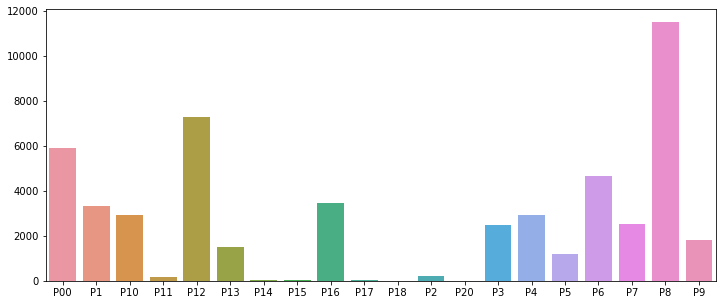

In [37]:
# Frequency of each lable - Y variable
# product 12 00 16 08 is picked the most
plt.figure(figsize=(12, 5))
sns.barplot(y_train.columns, y_train.sum())

<AxesSubplot:>

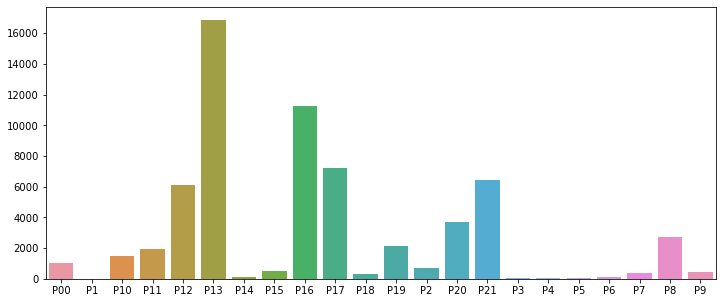

In [38]:
# Frequency of each lable - X variable
# product 13 16 17 is picked the most
plt.figure(figsize=(12, 5))
sns.barplot(mlb.classes_, X_train.iloc[:, 6:].sum())

<AxesSubplot:>

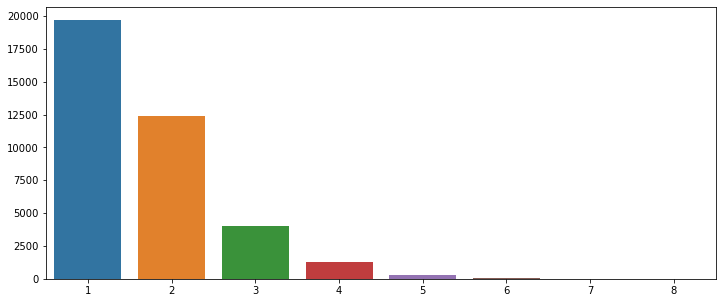

In [39]:
# we can see that majority 1-3 products are brough by a customer
# hence we are asked to predict only top three probabilities
plt.figure(figsize=(12, 5))
sns.barplot([1, 2, 3, 4, 5, 6, 7, 8],
            X_train.iloc[:, 6:].sum(axis=1).value_counts())

In [40]:
X_train.iloc[:, 6:].sum(axis=1).value_counts()

1    19696
2    12421
3     3986
4     1242
5      320
6       71
7        9
8        3
dtype: int64

In [41]:
X_train.iloc[:, 6:].sum()

P00     1014
P1        12
P10     1472
P11     1920
P12     6120
P13    16870
P14      129
P15      540
P16    11270
P17     7205
P18      338
P19     2122
P2       675
P20     3708
P21     6435
P3        61
P4        33
P5        34
P6       105
P7       359
P8      2695
P9       460
dtype: int64

In [42]:
y_train

,P00,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,P2,P20,P3,P4,P5,P6,P7,P8,P9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37743,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
37744,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
37745,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37746,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [45]:
# here we get an idea what products are purchaed by the customer for y variable

for i in y_train.columns:

    a = (y_train[i] == 1).value_counts()[1]
    print("{} = {}".format(i, a))

P00 = 5908
P1 = 3310
P10 = 2914
P11 = 186
P12 = 7285
P13 = 1494
P14 = 20
P15 = 41
P16 = 3478
P17 = 17
P18 = 2
P2 = 206
P20 = 4
P3 = 2486
P4 = 2943
P5 = 1211
P6 = 4675
P7 = 2526
P8 = 11518
P9 = 1833


In [46]:
# No null values
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37748 entries, 0 to 37747
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Gender             37748 non-null  object
 1   Age                37748 non-null  int64 
 2   Vintage            37748 non-null  int64 
 3   Is_Active          37748 non-null  int64 
 4   City_Category      37748 non-null  object
 5   Customer_Category  37748 non-null  object
 6   P00                37748 non-null  int32 
 7   P1                 37748 non-null  int32 
 8   P10                37748 non-null  int32 
 9   P11                37748 non-null  int32 
 10  P12                37748 non-null  int32 
 11  P13                37748 non-null  int32 
 12  P14                37748 non-null  int32 
 13  P15                37748 non-null  int32 
 14  P16                37748 non-null  int32 
 15  P17                37748 non-null  int32 
 16  P18                37748 non-null  int32

In [47]:
cathegorical_data = ['Gender', 'City_Category', 'Customer_Category']

In [48]:
for x in X_train.columns:

    count = X_train[x].value_counts().count()
    print("Feature in {} is {}".format(x, count))

Feature in Gender is 2
Feature in Age is 36
Feature in Vintage is 64
Feature in Is_Active is 2
Feature in City_Category is 2
Feature in Customer_Category is 3
Feature in P00 is 2
Feature in P1 is 2
Feature in P10 is 2
Feature in P11 is 2
Feature in P12 is 2
Feature in P13 is 2
Feature in P14 is 2
Feature in P15 is 2
Feature in P16 is 2
Feature in P17 is 2
Feature in P18 is 2
Feature in P19 is 2
Feature in P2 is 2
Feature in P20 is 2
Feature in P21 is 2
Feature in P3 is 2
Feature in P4 is 2
Feature in P5 is 2
Feature in P6 is 2
Feature in P7 is 2
Feature in P8 is 2
Feature in P9 is 2


In [49]:
# Gender and City_Category will be lablled and Customer_Category will be on
for x in X_train[cathegorical_data].columns:

    count = X_train[x].value_counts().count()
    print("Feature in {} is {}".format(x, count))

Feature in Gender is 2
Feature in City_Category is 2
Feature in Customer_Category is 3


<AxesSubplot:xlabel='Age', ylabel='Density'>

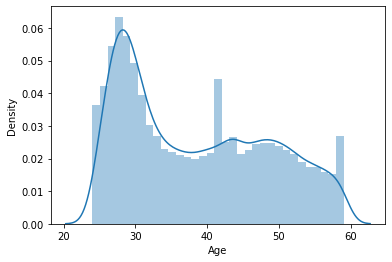

In [50]:
sns.distplot(df["Age"])

<AxesSubplot:xlabel='Vintage', ylabel='Density'>

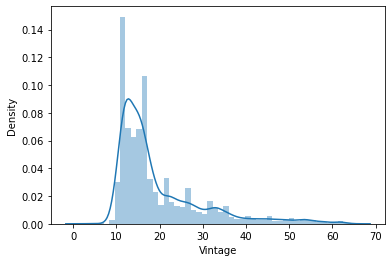

In [51]:
sns.distplot(df["Vintage"])

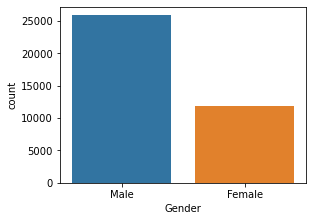

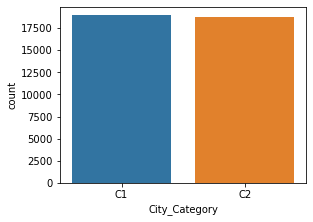

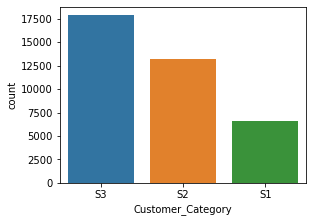

In [52]:
for i in X_train[cathegorical_data]:
    plt.figure(figsize=(15, 11))
    plt.subplot(3, 3, 1)
    sns.countplot(X_train[i])

    plt.show()

<AxesSubplot:xlabel='Gender', ylabel='Age'>

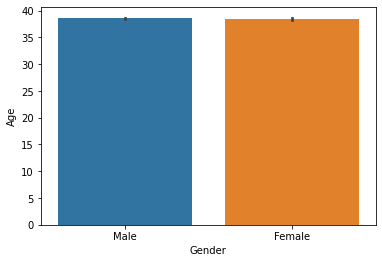

In [135]:
sns.barplot(x=df ["Gender"],data=df,y=df["Age"]) # Gender is eually distributed with respect to Age

<AxesSubplot:xlabel='Gender', ylabel='Vintage'>

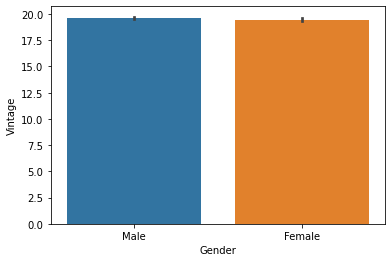

In [142]:
sns.barplot(x=df ["Gender"],data=df,y=df["Vintage"]) # Gender is eually distributed with respect to Vintage

In [53]:
binary_features = ['Gender', 'City_Category']

In [54]:
X_train[binary_features] = X_train[binary_features].apply(
    LabelEncoder().fit_transform)

In [55]:
X_train.head()

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,P00,P1,P10,P11,...,P2,P20,P21,P3,P4,P5,P6,P7,P8,P9
0,1,41,14,0,0,S3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,47,14,1,0,S2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,59,14,0,1,S2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,32,16,0,0,S2,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,30,15,0,1,S3,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [56]:
X_train = pd.get_dummies(data=X_train,
                         columns=["Customer_Category"],
                         drop_first=True)

In [57]:
X_train.head()

,Gender,Age,Vintage,Is_Active,City_Category,P00,P1,P10,P11,P12,...,P21,P3,P4,P5,P6,P7,P8,P9,Customer_Category_S2,Customer_Category_S3
0,1,41,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,47,14,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,59,14,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,0,32,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,30,15,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1


In [126]:
df

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1
0,CC264719,Male,41,14,0,C1,S3,[P16]
1,CC209679,Female,47,14,1,C1,S2,"[P13, P20]"
2,CC319633,Female,59,14,0,C2,S2,[P11]
3,CC231413,Female,32,16,0,C1,S2,"[P8, P13]"
4,CC259633,Male,30,15,0,C2,S3,"[P16, P17, P21]"
...,...,...,...,...,...,...,...,...
37743,CC314217,Male,28,24,1,C1,S2,[P16]
37744,CC388747,Male,36,11,0,C2,S2,"[P16, P17, P21]"
37745,CC318056,Male,44,26,1,C2,S2,[P14]
37746,CC373551,Female,56,15,1,C1,S2,"[P12, P13]"


In [58]:
# Create new feature --> Age/Vintage ratio
X_train['Age_Vintage_ratio'] = X_train['Age']/X_train['Vintage']


In [59]:
X_train.tail()

,Gender,Age,Vintage,Is_Active,City_Category,P00,P1,P10,P11,P12,...,P3,P4,P5,P6,P7,P8,P9,Customer_Category_S2,Customer_Category_S3,Age_Vintage_ratio
37743,1,28,24,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.166667
37744,1,36,11,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3.272727
37745,1,44,26,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1.692308
37746,0,56,15,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,3.733333
37747,1,29,13,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.230769


In [60]:
X_train.describe()

,Gender,Age,Vintage,Is_Active,City_Category,P00,P1,P10,P11,P12,...,P3,P4,P5,P6,P7,P8,P9,Customer_Category_S2,Customer_Category_S3,Age_Vintage_ratio
count,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,...,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000,37748.000000
mean,0.685864,38.521379,19.573169,0.264809,0.498225,0.026862,0.000318,0.038995,0.050864,0.162128,...,0.001616,0.000874,0.000901,0.002782,0.009510,0.071395,0.012186,0.351409,0.473270,2.364336
std,0.464177,10.121811,10.252417,0.441237,0.500003,0.161683,0.017827,0.193587,0.219722,0.368573,...,0.040167,0.029555,0.029999,0.052668,0.097058,0.257486,0.109717,0.477417,0.499292,1.085913
min,0.000000,24.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.403226
25%,0.000000,29.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.575758
50%,1.000000,37.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.235294
75%,1.000000,47.000000,23.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.052632
max,1.000000,59.000000,65.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,27.500000


In [61]:
y_train.head()  # was created before

,P00,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,P2,P20,P3,P4,P5,P6,P7,P8,P9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [62]:
X_train.head()

,Gender,Age,Vintage,Is_Active,City_Category,P00,P1,P10,P11,P12,...,P3,P4,P5,P6,P7,P8,P9,Customer_Category_S2,Customer_Category_S3,Age_Vintage_ratio
0,1,41,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.928571
1,0,47,14,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,3.357143
2,0,59,14,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4.214286
3,0,32,16,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,2.000000
4,1,30,15,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.000000


### Split to Train and Test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.3,
                                                    random_state=7)

In [64]:
print("X_train = {}, X_test = {}, y_train = {}, y_test = {}".format(
    X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train = (26423, 30), X_test = (11325, 30), y_train = (26423, 20), y_test = (11325, 20)


### Standardization

In [65]:
scales = MinMaxScaler()
std_scales = StandardScaler()

In [66]:
numerical_data = ["Age", "Vintage"]

In [67]:
X_train[numerical_data] = scales.fit_transform(X_train[numerical_data])
X_test[numerical_data] = scales.fit_transform(X_test[numerical_data])

### Model Building

#### Xgboost

In [57]:
xgbost=XGBClassifier(learning_rate=0.01,
                     n_estimators= 500,
                              gamma=3,
                              random_state=0)


In [58]:
multi_output_xgboost = MultiOutputClassifier(xgbost, n_jobs=-1)

In [59]:
multi_output_xgboost.fit(X_train, y_train)

KeyboardInterrupt: 

In [93]:
multi_output_xgboost.score(X_test, y_test)

0.25757174392935983

In [94]:
multi_output_xgboost.score(X_train, y_train)

0.2599629111001779

In [134]:
y_proba = multi_output_xgboost.predict_proba(X_test)

#### Cat Boost

In [50]:
catboost_model = CatBoostClassifier(iterations=500, 
    learning_rate=0.05)

In [51]:
multi_output_catboost = MultiOutputClassifier(catboost_model, n_jobs=-1)

In [52]:
multi_output_catboost.fit(X_train, y_train)

MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x0000020BC7BBEA30>,
                      n_jobs=-1)

In [53]:
multi_output_catboost.score(X_test, y_test)

0.29368653421633556

In [54]:
multi_output_catboost.score(X_train, y_train)

0.35949740756159404

In [55]:
y_proba = multi_output_catboost.predict_proba(X_test)

#### ANN

In [68]:
X_train.shape

(26423, 30)

In [69]:
y_train.shape

(26423, 20)

In [70]:
checkpoint = ModelCheckpoint("Model_stock_LSTM_checkpoint_new_data_.hdf5",
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True)

earlystopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0,  # minimum chnage to quality for early stopping
    patience=5,  # will wait for 5 time  if there is no change in loss
    verbose=1,
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.005,
                              patience=5,
                              verbose=1,
                              min_delta=0.001)

# we put our call backs into a callback list
callbacks = [checkpoint]

In [71]:
# create Model
model_ANN = Sequential()

# Leaky Relu is used to avoid dying relu problem
model_ANN.add(Dense(32, input_dim=X_train.shape[1], kernel_initializer='uniform', activation=LeakyReLU(alpha=0.01)))
model_ANN.add(Dense(16, kernel_initializer='normal',activation=LeakyReLU(alpha=0.01)))
model_ANN.add(Dense(8, kernel_initializer='normal', activation=LeakyReLU(alpha=0.01)))
model_ANN.add(Dense(y_train.shape[1], kernel_initializer='normal', activation='sigmoid'))

# compile Model
adam = Adam(lr=0.01)
# SGD = SGD(learning_rate=0.01, momentum=0.01)
model_ANN.compile(loss="binary_crossentropy",
                  optimizer=adam,
                  metrics=['accuracy'])

In [72]:
history = model_ANN.fit(X_train,
                        y_train,
                        validation_data=(X_test, y_test),
                        epochs=150,
                        batch_size=32)

Epoch 1/150
826/826 [==============================] - 16s 2ms/step - loss: 0.2398 - accuracy: 0.1542 - val_loss: 0.1507 - val_accuracy: 0.4586
Epoch 2/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1470 - accuracy: 0.4473 - val_loss: 0.1372 - val_accuracy: 0.4653
Epoch 3/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1364 - accuracy: 0.4770 - val_loss: 0.1335 - val_accuracy: 0.5001
Epoch 4/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1341 - accuracy: 0.4873 - val_loss: 0.1333 - val_accuracy: 0.4870
Epoch 5/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1308 - accuracy: 0.4960 - val_loss: 0.1307 - val_accuracy: 0.4845
Epoch 6/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1314 - accuracy: 0.4986 - val_loss: 0.1307 - val_accuracy: 0.4894
Epoch 7/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1312 - accuracy: 0.4968 - val_loss: 0.1300 - val_accuracy: 0.514

Epoch 58/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1249 - accuracy: 0.5074 - val_loss: 0.1273 - val_accuracy: 0.5061
Epoch 59/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1247 - accuracy: 0.5101 - val_loss: 0.1265 - val_accuracy: 0.5113
Epoch 60/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1263 - accuracy: 0.4970 - val_loss: 0.1267 - val_accuracy: 0.5077
Epoch 61/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1237 - accuracy: 0.5091 - val_loss: 0.1263 - val_accuracy: 0.4973
Epoch 62/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1242 - accuracy: 0.5072 - val_loss: 0.1262 - val_accuracy: 0.5100
Epoch 63/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1252 - accuracy: 0.5031 - val_loss: 0.1264 - val_accuracy: 0.5038
Epoch 64/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1258 - accuracy: 0.5011 - val_loss: 0.1270 - val_accuracy:

Epoch 115/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1242 - accuracy: 0.5086 - val_loss: 0.1316 - val_accuracy: 0.5136
Epoch 116/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1234 - accuracy: 0.5122 - val_loss: 0.1275 - val_accuracy: 0.5072
Epoch 117/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1232 - accuracy: 0.5073 - val_loss: 0.1273 - val_accuracy: 0.5087
Epoch 118/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1244 - accuracy: 0.5097 - val_loss: 0.1280 - val_accuracy: 0.4916
Epoch 119/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1235 - accuracy: 0.5062 - val_loss: 0.1277 - val_accuracy: 0.5111
Epoch 120/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1231 - accuracy: 0.5088 - val_loss: 0.1317 - val_accuracy: 0.5072
Epoch 121/150
826/826 [==============================] - 1s 1ms/step - loss: 0.1244 - accuracy: 0.5075 - val_loss: 0.1280 - val_ac

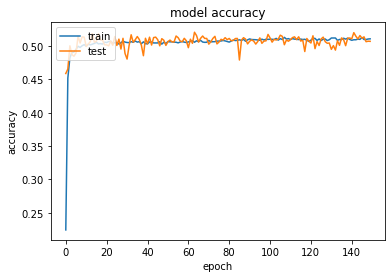

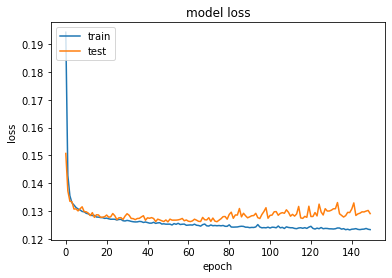

In [73]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])  # Train Accuracy
plt.plot(history.history['val_accuracy'])  # Test Accuracy
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [74]:
y_pred_ANN = model_ANN.predict(X_test)  # prediction on test

In [75]:
average_precision_score(
    y_test, y_pred_ANN,
    average='weighted')  # chekcing the average_precision_score

0.6235095611024928

In [76]:
pred_ANN = model_ANN.predict_proba(X_test)  # predicted probablity

In [77]:
pred_ANN[1]

array([1.03573599e-04, 5.95724583e-02, 2.97149807e-01, 2.27481127e-04,
       1.19421624e-04, 2.53002224e-08, 2.12755049e-06, 6.96525676e-05,
       6.21617289e-07, 5.84374860e-09, 6.27892893e-09, 1.13508105e-03,
       2.59147037e-10, 5.66207469e-02, 2.73003101e-01, 7.61321187e-02,
       6.91144764e-02, 3.28097939e-02, 4.78646219e-01, 4.74908352e-02],
      dtype=float32)

In [78]:
np.argmax(pred_ANN[1])

18

#### Prediction Working for ANN

In [84]:
len (pred_ANN)

11325

In [85]:
int_char

{0: 'P00',
 1: 'P1',
 2: 'P10',
 3: 'P11',
 4: 'P12',
 5: 'P13',
 6: 'P14',
 7: 'P15',
 8: 'P16',
 9: 'P17',
 10: 'P18',
 11: 'P2',
 12: 'P20',
 13: 'P3',
 14: 'P4',
 15: 'P5',
 16: 'P6',
 17: 'P7',
 18: 'P8',
 19: 'P9'}

In [86]:
np.argsort(model_ANN.predict_proba(X_test)[1])

array([12,  9, 10,  5,  8,  6,  7,  0,  4,  3, 11, 17, 19, 13,  1, 16, 15,
       14,  2, 18], dtype=int64)

In [87]:
([i for i in np.argsort(pred_ANN[1])])[-3:]

[14, 2, 18]

In [88]:
([(i,x) for (i,x) in enumerate(np.argsort(pred_ANN[1]))])[-3:]

[(17, 14), (18, 2), (19, 18)]

In [89]:
[i[1] for i in ([(i,x) for (i,x) in enumerate(np.argsort(pred_ANN[1]))])[-3:]] # index number for top 3 prababilities

[14, 2, 18]

### Prediction Purpose 

#### working breakdown for the function 

In [82]:
int_char = dict((i, c) for i, c in enumerate(y_train))

In [83]:
int_char

{0: 'P00',
 1: 'P1',
 2: 'P10',
 3: 'P11',
 4: 'P12',
 5: 'P13',
 6: 'P14',
 7: 'P15',
 8: 'P16',
 9: 'P17',
 10: 'P18',
 11: 'P2',
 12: 'P20',
 13: 'P3',
 14: 'P4',
 15: 'P5',
 16: 'P6',
 17: 'P7',
 18: 'P8',
 19: 'P9'}

In [209]:
int_char[np.argmax(
    np.array(y_train))]  # we will use this for prediction (basic idea)

'P6'

In [210]:
np.transpose(y_proba)

array([[[9.99296310e-01, 9.88977256e-01, 9.73568079e-01, ...,
         9.81867361e-01, 7.56639318e-01, 9.91093120e-01],
        [9.89994005e-01, 9.34701149e-01, 6.49889790e-01, ...,
         9.47653221e-01, 4.83530202e-01, 9.40736976e-01],
        [6.23291512e-01, 9.73698213e-01, 9.74398735e-01, ...,
         9.84091010e-01, 7.38060000e-01, 9.48009252e-01],
        ...,
        [9.86733321e-01, 9.32824704e-01, 7.35088907e-01, ...,
         9.45915399e-01, 4.58052333e-01, 9.52618960e-01],
        [9.99777047e-01, 9.94260686e-01, 9.83813884e-01, ...,
         7.97189702e-01, 4.50819341e-02, 9.83839968e-01],
        [9.97485793e-01, 8.35556508e-01, 9.80429377e-01, ...,
         9.52924379e-01, 6.72355726e-01, 9.88777088e-01]],

       [[7.03689656e-04, 1.10227441e-02, 2.64319208e-02, ...,
         1.81326393e-02, 2.43360682e-01, 8.90687999e-03],
        [1.00059953e-02, 6.52988508e-02, 3.50110210e-01, ...,
         5.23467789e-02, 5.16469798e-01, 5.92630238e-02],
        [3.76708488e-01, 

In [211]:
# so we will have to transpose it it matches the X_test len
len(np.transpose(y_proba)[0])

11325

In [212]:
np.transpose(y_proba)[0][10]  # each represent probablity for 20 classes

array([0.9999651 , 0.4312593 , 0.99809836, 0.99997272, 0.99933894,
       0.99998725, 0.99999264, 0.99995318, 0.99999546, 0.99996872,
       0.99982221, 0.99996225, 0.99987031, 0.72773851, 0.67686443,
       0.88027658, 0.80843075, 0.49691133, 0.02492588, 0.75225302])

In [213]:
np.transpose(y_proba)[0][10]

array([0.9999651 , 0.4312593 , 0.99809836, 0.99997272, 0.99933894,
       0.99998725, 0.99999264, 0.99995318, 0.99999546, 0.99996872,
       0.99982221, 0.99996225, 0.99987031, 0.72773851, 0.67686443,
       0.88027658, 0.80843075, 0.49691133, 0.02492588, 0.75225302])

In [214]:
np.argmax(np.transpose(y_proba)[0][10])  # 10th index has the high probability

8

In [215]:
np.max(np.transpose(y_proba)[0][10])  # highest probability

0.9999954571976728

In [216]:
# -> the highest probability index no is in the last which is four
# argmax sorts in assending order
# we will ned the last index number equvalent to the top three probabality code as below
np.argsort(np.transpose(y_proba)[0][10])

array([18,  1, 17, 14, 13, 19, 16, 15,  2,  4, 10, 12,  7, 11,  0,  9,  3,
        5,  6,  8], dtype=int64)

In [217]:
([i for i in np.argsort(np.transpose (y_proba)[0][10])])[-3:] # -> got the index number of the 3 highest probality ->used this logic

[5, 6, 8]

In [218]:
 # since the value have the index number from argsort, we will follow the below code ro get the index number of top 3 
sorted([(i,x) for (i,x) in enumerate(np.argsort(np.transpose (y_proba)[0][10]))])[-3:]

[(17, 5), (18, 6), (19, 8)]

In [219]:
# -> got the index number of teh 3 highest probality 
[i[1] for i in ([(i,x) for (i,x) in enumerate(np.argsort(np.transpose (y_proba)[0][10]))])[-3:]]

[5, 6, 8]

In [220]:
len(X_test)

11325

In [221]:
int_char

{0: 'P00',
 1: 'P1',
 2: 'P10',
 3: 'P11',
 4: 'P12',
 5: 'P13',
 6: 'P14',
 7: 'P15',
 8: 'P16',
 9: 'P17',
 10: 'P18',
 11: 'P2',
 12: 'P20',
 13: 'P3',
 14: 'P4',
 15: 'P5',
 16: 'P6',
 17: 'P7',
 18: 'P8',
 19: 'P9'}

#### Function for prediction the

In [90]:
# creation of dictionary for predicting Y variable
int_char = dict((i, c) for i, c in enumerate(y_train))

prediction = []
for i in range(len(X_test)):
    # transposese the Df -> this step is used if you use MultiLabelBinarizer not for Neural Network
    #transpose = np.transpose(y_proba)[0][i]

    # -> out [ 4, 18, 16, 17,  2, 13, 14, 19, 15] number denotes ranks
    # highest probablity will have zero rank
    rank = np.argsort(pred_ANN[i])

    # -> well get the index number for the top highest probablity as problem statement
    # you take the index of the top three by [-3:] highest probablity will have zero rank
    # top_3_proba= [i[1] for i in ([(i,x) for (i,x) in enumerate(rank)])[-3:]]

    # to get the Top three probabilities
    top_3_proba = ([i for i in rank])[-3:]

    pred = [int_char[x] for x in top_3_proba]
    prediction.append(pred)

In [91]:
prediction

[['P6', 'P8', 'P12'],
 ['P4', 'P10', 'P8'],
 ['P00', 'P6', 'P8'],
 ['P00', 'P6', 'P8'],
 ['P8', 'P1', 'P00'],
 ['P6', 'P8', 'P12'],
 ['P7', 'P6', 'P4'],
 ['P4', 'P10', 'P8'],
 ['P10', 'P8', 'P1'],
 ['P12', 'P8', 'P00'],
 ['P7', 'P4', 'P8'],
 ['P00', 'P6', 'P8'],
 ['P4', 'P10', 'P8'],
 ['P4', 'P8', 'P12'],
 ['P12', 'P6', 'P8'],
 ['P16', 'P12', 'P13'],
 ['P1', 'P8', 'P00'],
 ['P1', 'P13', 'P16'],
 ['P4', 'P7', 'P6'],
 ['P00', 'P6', 'P8'],
 ['P12', 'P6', 'P8'],
 ['P1', 'P8', 'P00'],
 ['P1', 'P13', 'P16'],
 ['P6', 'P3', 'P8'],
 ['P6', 'P8', 'P12'],
 ['P5', 'P10', 'P4'],
 ['P1', 'P8', 'P00'],
 ['P3', 'P1', 'P6'],
 ['P1', 'P12', 'P8'],
 ['P6', 'P8', 'P12'],
 ['P10', 'P4', 'P8'],
 ['P16', 'P8', 'P00'],
 ['P8', 'P4', 'P10'],
 ['P12', 'P8', 'P00'],
 ['P3', 'P8', 'P12'],
 ['P6', 'P8', 'P00'],
 ['P8', 'P12', 'P1'],
 ['P4', 'P8', 'P12'],
 ['P10', 'P8', 'P11'],
 ['P8', 'P1', 'P00'],
 ['P6', 'P00', 'P8'],
 ['P6', 'P8', 'P00'],
 ['P6', 'P00', 'P8'],
 ['P12', 'P8', 'P1'],
 ['P10', 'P8', 'P12'],
 ['P00

In [92]:
len(prediction)

11325

### Prediction for the given test set 

#### we will have to do the same transformation as for training set and predict using the above function 

In [100]:
# loading the Test data
df_val = pd.read_csv('test_VkM91FT.csv',
                     converters={"Product_Holding_B1": literal_eval})
# drop Customer id
df_val = df_val.iloc[:, 1:]

In [101]:
df_val = df_val.join(
    pd.DataFrame(mlb.fit_transform(df_val.pop("Product_Holding_B1")),
                 columns=mlb.classes_))

# binary feature conversion
df_val[binary_features] = df_val[binary_features].apply(
    LabelEncoder().fit_transform)

# categorical feature conversion
df_val = pd.get_dummies(data=df_val,
                        columns=["Customer_Category"],
                        drop_first=True)

# Creation of new feature -> Age_Vintage_ratio
df_val['Age_Vintage_ratio'] = df_val['Age']/df_val['Vintage']

# normalization of continous variable -> note Age vinage ratio is not normalised 
df_val[numerical_data] = scales.fit_transform(df_val[numerical_data])

In [105]:
df_val

,Gender,Age,Vintage,Is_Active,City_Category,P00,P1,P10,P11,P12,...,P3,P4,P5,P6,P7,P8,P9,Customer_Category_S2,Customer_Category_S3,Age_Vintage_ratio
0,0,0.200000,0.363636,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1.000000
1,1,0.114286,0.441558,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0.756757
2,1,0.200000,0.116883,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.583333
3,0,0.885714,0.103896,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5.000000
4,1,0.771429,0.597403,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.040816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,0,0.371429,0.103896,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.363636
20323,1,0.142857,0.142857,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2.071429
20324,1,0.057143,0.116883,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.166667
20325,0,0.571429,0.207792,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,1,2.315789


In [106]:
df_val.iloc[:, 5:-2].sum()

P00                      496
P1                         3
P10                      774
P11                     1017
P12                     3323
P13                     9202
P14                       74
P15                      322
P16                     6057
P17                     3826
P18                      195
P19                     1262
P2                       325
P20                     1993
P21                     3382
P3                        37
P4                        22
P5                        17
P6                        60
P7                       234
P8                      1455
P9                       264
Customer_Category_S2    7161
dtype: int64

In [110]:
df_val.iloc[:, 5:-3]

,P00,P1,P10,P11,P12,P13,P14,P15,P16,P17,...,P2,P20,P21,P3,P4,P5,P6,P7,P8,P9
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20322,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20323,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20324,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20325,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,1


<AxesSubplot:>

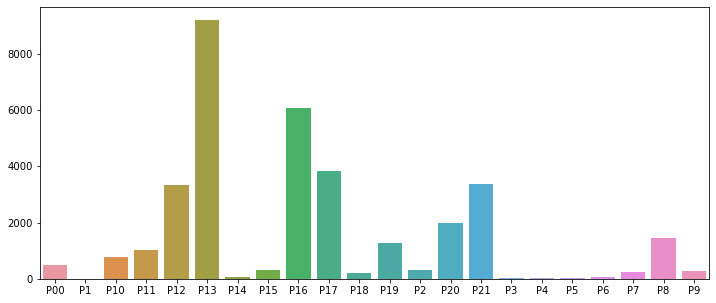

In [111]:
# Frequency of each lable
# product 13 15 17 is picked the most
plt.figure(figsize=(12, 5))
sns.barplot(df_val.iloc[:, 5:-3].columns, df_val.iloc[:, 5:-3].sum())

In [115]:
y_proba_val = model_ANN.predict_proba(df_val)

prediction_val = []
for i in range(len(df_val)):
    # transposese the Df
    #transpose = np.transpose(y_proba_val)[0][i]

    # -> out [ 4, 18, 16, 17,  2, 13, 14, 19, 15] number denotes ranks
    # highest probablity will have zero rank
    rank = np.argsort(y_proba_val[i])

    # -> well get the index number for the top highest probablity as problem statement
    # you take the index of the top three by [-3:] highest probablity will have zero rank
    # top_3_proba= [i[1] for i in ([(i,x) for (i,x) in enumerate(rank)])[-3:]]

    top_3_proba = ([i for i in rank])[-3:]  # -> pic the top 3 Probabilities

    pred = [int_char[x] for x in top_3_proba]
    prediction_val.append(pred)

In [121]:
prediction_val

[['P4', 'P10', 'P8'],
 ['P10', 'P1', 'P8'],
 ['P00', 'P13', 'P16'],
 ['P6', 'P10', 'P8'],
 ['P8', 'P1', 'P00'],
 ['P9', 'P8', 'P12'],
 ['P1', 'P13', 'P16'],
 ['P4', 'P8', 'P12'],
 ['P12', 'P6', 'P8'],
 ['P6', 'P4', 'P8'],
 ['P10', 'P4', 'P8'],
 ['P00', 'P13', 'P16'],
 ['P3', 'P1', 'P8'],
 ['P1', 'P2', 'P00'],
 ['P10', 'P6', 'P8'],
 ['P6', 'P8', 'P12'],
 ['P7', 'P3', 'P8'],
 ['P1', 'P6', 'P4'],
 ['P00', 'P6', 'P8'],
 ['P12', 'P8', 'P00'],
 ['P8', 'P1', 'P00'],
 ['P12', 'P8', 'P00'],
 ['P12', 'P13', 'P16'],
 ['P10', 'P6', 'P8'],
 ['P12', 'P6', 'P8'],
 ['P1', 'P7', 'P6'],
 ['P6', 'P8', 'P12'],
 ['P6', 'P8', 'P00'],
 ['P6', 'P4', 'P8'],
 ['P12', 'P8', 'P00'],
 ['P1', 'P8', 'P00'],
 ['P00', 'P6', 'P8'],
 ['P1', 'P8', 'P00'],
 ['P1', 'P13', 'P16'],
 ['P12', 'P8', 'P00'],
 ['P1', 'P13', 'P16'],
 ['P9', 'P8', 'P12'],
 ['P1', 'P8', 'P12'],
 ['P6', 'P8', 'P12'],
 ['P6', 'P8', 'P12'],
 ['P4', 'P10', 'P8'],
 ['P1', 'P12', 'P8'],
 ['P11', 'P13', 'P16'],
 ['P1', 'P8', 'P00'],
 ['P12', 'P8', 'P00'],
